This notebook contains simillar information as notebook MFCC-ML in which all the operations were performed on training set. In this notebook, operations will be performed at an evaluation set, which contains more samples. I will also try to introduce manual dataset balancing.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import svm
from sklearn import model_selection
from sklearn import linear_model
from sklearn.model_selection import KFold
from itertools import product
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.svm import SVC


In [26]:
file_path = "MFCC_EVAL_FEATURES_LABELED.csv"  


eval_df = pd.read_csv(file_path, delimiter=';')

# Drop the first row containing column numbers
eval_df.columns = eval_df.iloc[0]
eval_df = eval_df.drop(eval_df.index[0])

# Drop rows with NaN values
eval_df = eval_df.dropna()

# Drop the 'filename' column
eval_df = eval_df.drop(columns=['filename'])

# Transform 'spoof' to 0 and 'bonafide' to 1 in the 'Label' column
eval_df['Label'] = eval_df['Label'].map({'spoof': 0, 'bonafide': 1})

# Display the cleaned DataFrame
print(eval_df.head())



C:\Users\vjesc\AppData\Local\Temp\ipykernel_7588\3870491119.py:4: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  eval_df = pd.read_csv(file_path, delimiter=';')


0  Label      mfcc_1     mfcc_2      mfcc_3     mfcc_4      mfcc_5     mfcc_6  \
1      0    -205.015  139.56729   -46.88559    58.0535  -15.933013  6.7276654   
2      0   -285.1221  113.41989   -8.467953  40.317867   -16.11112  15.670601   
3      0   -232.6206  165.60791  -27.245367   49.38298    -2.76139  0.9697761   
4      0  -301.97018   69.38392  -44.413116  61.301666  -18.442436   -24.4736   
5      0  -317.13718  126.69181   -65.77651  22.715647  -28.936966  -8.015325   

0       mfcc_7      mfcc_8      mfcc_9  ...     mfcc_11     mfcc_12  \
1   -16.274055   -8.880779  -18.400627  ...  -5.2172213   -9.359123   
2    -8.908045   3.4256968  -21.877472  ...   -7.011489  -17.329466   
3  -0.86966246  -22.713154   -11.96604  ...   -9.854653  0.26017064   
4   -13.685907  -19.423687  -21.381638  ...   -8.331615  -2.3441758   
5   -23.152832  -25.740723   -21.53388  ...  -10.727237   -7.691421   

0     mfcc_13     mfcc_14    mfcc_15     mfcc_16     mfcc_17     mfcc_18  \
1   2.1554

In [44]:
# Separate features and labels
X = eval_df.drop(columns=["Label"])  # X contains features without columns Label and ID
Y = eval_df["Label"]  # y contains Labels (0 = Spoofed, 1 = Bonafide)

In [46]:
# Check class distribution
class_counts = pd.Series(Y).value_counts()
print("Class Distribution:\n", class_counts)

Class Distribution:
 Label
0    63882
1     7355
Name: count, dtype: int64


Create balanced dataset.

In [49]:
# Create a balanced DataFrame
bonafide_samples = eval_df[eval_df['Label'] == 1]
spoof_samples = eval_df[eval_df['Label'] == 0].sample(n=len(bonafide_samples), random_state=2141831)

balanced_df = pd.concat([bonafide_samples, spoof_samples]).reset_index(drop=True)

# Display the cleaned DataFrame
print(balanced_df.head())

0  Label      mfcc_1     mfcc_2      mfcc_3     mfcc_4      mfcc_5  \
0      1  -402.97076   91.89963  -0.2804517   9.626705   2.1565902   
1      1  -361.59763   98.52667  -10.046808   30.58372   1.0662949   
2      1   -339.0704  71.917534  -15.632757   42.56405  -6.0490546   
3      1   -285.8647  96.458115  -16.327173   35.89828  -12.864523   
4      1  -438.57904   80.79588   1.4521991  28.648617  -3.9705534   

0      mfcc_6       mfcc_7      mfcc_8      mfcc_9  ...     mfcc_11  \
0  0.74882054  -0.84038013  -0.8784534  -6.6335406  ...   -6.147995   
1   3.7170265   -7.6777797  -2.9077327   -5.661212  ...  -7.9528236   
2     4.45085   -11.570544  -2.0293078   -12.01788  ...   -9.456054   
3   1.9376915   -17.821392  -3.0684001  -10.632819  ...  -13.541451   
4   16.799059   -0.3702833    2.352389   -3.333776  ...   1.6654994   

0     mfcc_12     mfcc_13      mfcc_14     mfcc_15      mfcc_16     mfcc_17  \
0  -2.2708023   3.2372456    -4.231891  -2.7242274  -0.21906956  -0.62767

In [51]:
# Separate features and labels
X_bal = balanced_df.drop(columns=["Label"])  # X contains features without columns Label and ID
Y_bal = balanced_df["Label"]  # y contains Labels (0 = Spoofed, 1 = Bonafide)

In [53]:
# Check class distribution
class_counts = pd.Series(Y_bal).value_counts()
print("Class Distribution:\n", class_counts)

Class Distribution:
 Label
1    7355
0    7355
Name: count, dtype: int64


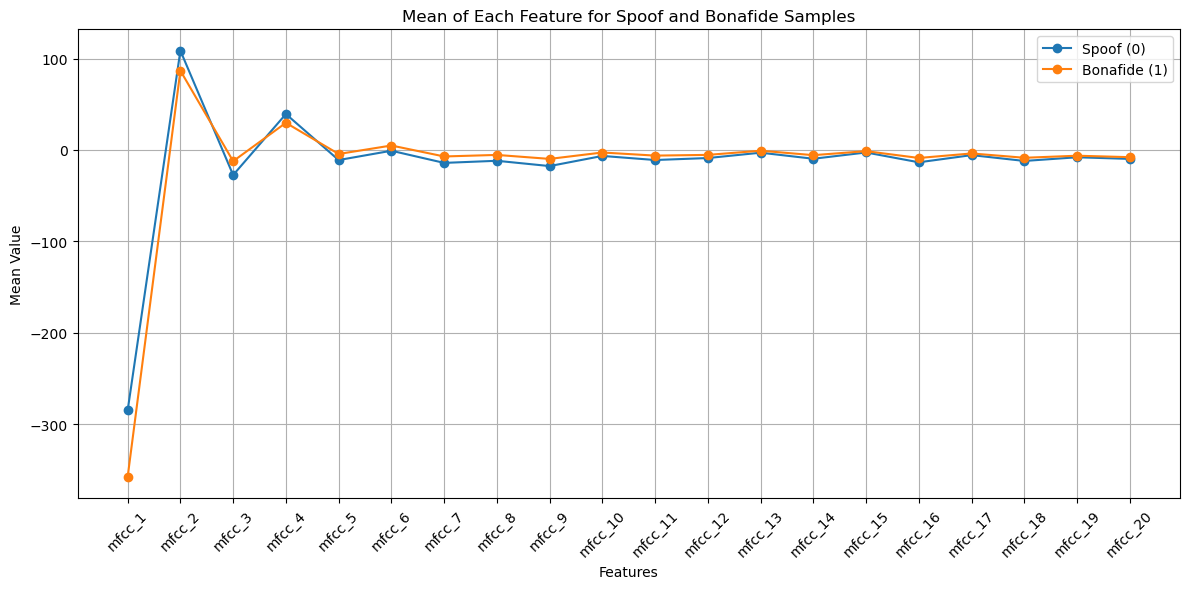

In [57]:
# Convert all feature columns to numeric, forcing errors to NaN
for col in balanced_df.columns:
    if col != "Label":
        balanced_df[col] = pd.to_numeric(balanced_df[col], errors='coerce')

# Calculate mean of each feature for both labels
mean_spoof = balanced_df[balanced_df['Label'] == 0].mean()
mean_bonafide = balanced_df[balanced_df['Label'] == 1].mean()

# Plot the means
plt.figure(figsize=(12, 6))
plt.plot(mean_spoof.index[1:], mean_spoof.values[1:], label='Spoof (0)', marker='o')
plt.plot(mean_bonafide.index[1:], mean_bonafide.values[1:], label='Bonafide (1)', marker='o')

plt.xlabel('Features')
plt.ylabel('Mean Value')
plt.title('Mean of Each Feature for Spoof and Bonafide Samples')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [59]:
X_train, X_test, Y_train, Y_test = train_test_split(X_bal, Y_bal, test_size = 0.2, random_state = 2141831)

print("Training size (Original):", X_train.shape[0])
print("Test size (Original):", X_test.shape[0])

Training size (Original): 11768
Test size (Original): 2942


In [61]:
clf = DecisionTreeClassifier(random_state=214831)
clf.fit(X_train, Y_train)

Y_pred = clf.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
roc_score = roc_auc_score(Y_test, Y_pred)

report = classification_report(Y_test, Y_pred)
print("Classification Report: \n", report)

Classification Report: 
               precision    recall  f1-score   support

           0       0.83      0.84      0.83      1455
           1       0.84      0.83      0.84      1487

    accuracy                           0.83      2942
   macro avg       0.83      0.83      0.83      2942
weighted avg       0.83      0.83      0.83      2942



In [63]:
rf = RandomForestClassifier(n_estimators=200, max_depth=100, random_state=2141831)
rf.fit(X_train, Y_train)

Y_pred = rf.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)
class_report = classification_report(Y_test, Y_pred)

# Print evaluation metrics
print(f"Model Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

Model Accuracy: 0.9079

Confusion Matrix:
 [[1273  182]
 [  89 1398]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.87      0.90      1455
           1       0.88      0.94      0.91      1487

    accuracy                           0.91      2942
   macro avg       0.91      0.91      0.91      2942
weighted avg       0.91      0.91      0.91      2942



In [65]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size = 0.2, random_state = 2141831)


In [67]:
# Train XGBoost Classifier
xgb_model = XGBClassifier(
    n_estimators=100,  # Number of trees
    max_depth=6,  # Depth of each tree
    learning_rate=0.1,  # Step size shrinkage
    subsample=0.8,  # Percentage of samples used per tree
    colsample_bytree=0.8,  # Percentage of features used per tree
    random_state=2141831
)

xgb_model.fit(X_train, Y_train)

# Predictions on test set
Y_pred_xgb = xgb_model.predict(X_test)

# Evaluate model performance
accuracy_xgb = accuracy_score(Y_test, Y_pred_xgb)
conf_matrix_xgb = confusion_matrix(Y_test, Y_pred_xgb)
class_report_xgb = classification_report(Y_test, Y_pred_xgb)

# Print model evaluation results
print(f"\nXGBoost Model Accuracy: {accuracy_xgb:.4f}")
print("\nConfusion Matrix:\n", conf_matrix_xgb)
print("\nClassification Report:\n", class_report_xgb)


XGBoost Model Accuracy: 0.9535

Confusion Matrix:
 [[12612   145]
 [  517   974]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97     12757
           1       0.87      0.65      0.75      1491

    accuracy                           0.95     14248
   macro avg       0.92      0.82      0.86     14248
weighted avg       0.95      0.95      0.95     14248



C:\Users\vjesc\AppData\Local\Temp\ipykernel_7588\959801104.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  all_leading_digits_label_0 = label_0_data[mfcc_columns].applymap(first_non_zero_leading_digit).values.flatten()
C:\Users\vjesc\AppData\Local\Temp\ipykernel_7588\959801104.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  all_leading_digits_label_1 = label_1_data[mfcc_columns].applymap(first_non_zero_leading_digit).values.flatten()


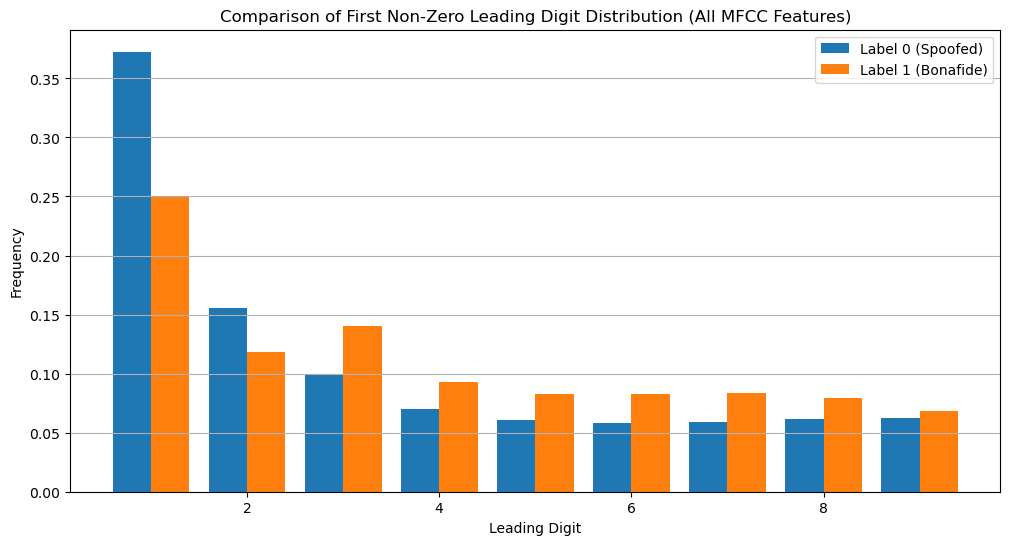

In [69]:
# Function to extract the first non-zero leading digit from a number
def first_non_zero_leading_digit(x):
    x = abs(float(x))
    if x == 0:
        return 0
    while x < 1:
        x *= 10
    return int(str(int(x)).lstrip('0')[0]) if str(int(x)).lstrip('0') else 0

# Select MFCC columns
mfcc_columns = [col for col in df_cleaned.columns if col.startswith('mfcc_')]

# Filter data for label 0 and label 1
label_0_data = df_cleaned[df_cleaned['Label'] == 0]
label_1_data = df_cleaned[df_cleaned['Label'] == 1]

# Combine all MFCC features into one series of leading digits
all_leading_digits_label_0 = label_0_data[mfcc_columns].applymap(first_non_zero_leading_digit).values.flatten()
all_leading_digits_label_1 = label_1_data[mfcc_columns].applymap(first_non_zero_leading_digit).values.flatten()

# Calculate frequency distribution of leading digits
combined_leading_digit_stats_label_0 = pd.Series(all_leading_digits_label_0).value_counts(normalize=True).sort_index()
combined_leading_digit_stats_label_1 = pd.Series(all_leading_digits_label_1).value_counts(normalize=True).sort_index()

# Plotting the combined leading digit statistics for both labels
plt.figure(figsize=(12, 6))
plt.bar(combined_leading_digit_stats_label_0.index - 0.2, combined_leading_digit_stats_label_0.values, width=0.4, label='Label 0 (Spoofed)')
plt.bar(combined_leading_digit_stats_label_1.index + 0.2, combined_leading_digit_stats_label_1.values, width=0.4, label='Label 1 (Bonafide)')

plt.title('Comparison of First Non-Zero Leading Digit Distribution (All MFCC Features)')
plt.xlabel('Leading Digit')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y')
plt.show()


In [71]:
# Train SVM Classifier with RBF kernel
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=2141831)
svm_model.fit(X_train, Y_train)

# Predictions on test set
Y_pred_svm = svm_model.predict(X_test)

# Evaluate model performance
accuracy_svm = accuracy_score(Y_test, Y_pred_svm)
conf_matrix_svm = confusion_matrix(Y_test, Y_pred_svm)
class_report_svm = classification_report(Y_test, Y_pred_svm)

# Print model evaluation results
print(f"\nSVM Model Accuracy: {accuracy_svm:.4f}")
print("\nConfusion Matrix:\n", conf_matrix_svm)
print("\nClassification Report:\n", class_report_svm)


SVM Model Accuracy: 0.9613

Confusion Matrix:
 [[12615   142]
 [  410  1081]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     12757
           1       0.88      0.73      0.80      1491

    accuracy                           0.96     14248
   macro avg       0.93      0.86      0.89     14248
weighted avg       0.96      0.96      0.96     14248

